<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/BAMFOREST_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install geopandas shapely fiona pyproj rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 93.9 MB/s eta 0:00:00


In [5]:
import os
import json
import numpy as np
import rasterio
from collections import defaultdict
import cv2

In [ ]:
SOURCE_UNMERGED_IMG_DIR = "/content/drive/MyDrive/masterthesis/data/TestSet12023_UAV"
SOURCE_JSON_PATH = "/content/drive/MyDrive/masterthesis/data/instances_tree_TestSet12023.json"

OUTPUT_JSON_PATH = "/content/drive/MyDrive/masterthesis/data/merged_annotations_for_manual_images.json"
SUBCATEGORIES_TO_PROCESS = ['78', '77', '38', '97', '117']

In [ ]:
print(f"Loading original annotation data from: {SOURCE_JSON_PATH}")
with open(SOURCE_JSON_PATH, 'r') as f:
    coco_data = json.load(f)

annotations_by_image_id = defaultdict(list)
for ann in coco_data['annotations']:
    annotations_by_image_id[ann['image_id']].append(ann)

grouped_files = defaultdict(list)
for img in coco_data['images']:
    file_name = img['file_name']
    parts = file_name.split('_')
    if len(parts) == 3 and parts[0] == 'Hain':
        subcategory = parts[1]
        if subcategory in SUBCATEGORIES_TO_PROCESS:
            try:
                index = int(parts[2].split('.')[0])
                grouped_files[subcategory].append({'file': file_name, 'index': index, 'id': img['id']})
            except ValueError:
                continue

print(f"Found annotation data for subcategories: {list(grouped_files.keys())}")

Loading original annotation data from: /content/drive/MyDrive/masterthesis/data/instances_tree_TestSet12023.json
Found annotation data for subcategories: ['117', '38', '77', '78', '97']


In [ ]:
print("\nStarting Geospatially-Aware Annotation Merging...")
new_coco_data = { "info": coco_data['info'], "licenses": coco_data['licenses'], "categories": coco_data['categories'], "images": [], "annotations": [] }
new_image_id = 1
new_annotation_id = 1

for subcategory, files in grouped_files.items():
    if not files: continue

    merged_image_name = f"Hain_{subcategory}.tif"
    print(f"\nProcessing annotations for: {merged_image_name} ({len(files)} tiles)")

    # --- Step 1: Determine the total geographic extent of all tiles ---
    total_bounds = None
    tile_metadata = {}
    for tile_info in files:
        tile_path = os.path.join(SOURCE_UNMERGED_IMG_DIR, tile_info['file'])
        try:
            with rasterio.open(tile_path) as src:
                if total_bounds is None:
                    total_bounds = list(src.bounds)
                else:
                    total_bounds[0] = min(total_bounds[0], src.bounds.left)
                    total_bounds[1] = min(total_bounds[1], src.bounds.bottom)
                    total_bounds[2] = max(total_bounds[2], src.bounds.right)
                    total_bounds[3] = max(total_bounds[3], src.bounds.top)
                # Store metadata for later
                tile_metadata[tile_info['file']] = {'bounds': src.bounds, 'res': src.res}
        except rasterio.errors.RasterioIOError:
            print(f"  ❌ ERROR: Could not open source tile: {tile_path}")
            continue

    if total_bounds is None: continue

    #  Define the properties of the merged canvas
    merged_origin_x, merged_origin_y = total_bounds[0], total_bounds[3]
    pixel_size_x, pixel_size_y = tile_metadata[files[0]['file']]['res']
    merged_width = int(round((total_bounds[2] - total_bounds[0]) / pixel_size_x))
    merged_height = int(round((total_bounds[3] - total_bounds[1]) / pixel_size_y))

    print(f"  Calculated merged canvas size: {merged_width} x {merged_height} pixels")

    # Process annotations for each tile with precise offsets
    for tile_info in files:
        tile_bounds = tile_metadata[tile_info['file']]['bounds']

        # Calculate the pixel offset of this tile's origin on the merged canvas
        x_offset = int(round((tile_bounds.left - merged_origin_x) / pixel_size_x))
        y_offset = int(round((merged_origin_y - tile_bounds.top) / pixel_size_y))

        image_id = tile_info['id']
        for ann in annotations_by_image_id[image_id]:
            new_ann = ann.copy()
            new_seg = []
            for seg_part in ann['segmentation']:
                coords = np.array(seg_part).reshape(-1, 2)
                coords[:, 0] += x_offset
                coords[:, 1] += y_offset
                new_seg.append(coords.flatten().tolist())

            new_ann['segmentation'] = new_seg
            new_ann['image_id'] = new_image_id
            new_ann['id'] = new_annotation_id
            new_coco_data['annotations'].append(new_ann)
            new_annotation_id += 1

    # Add the manually merged image's info 
    new_coco_data['images'].append({
        "id": new_image_id,
        "file_name": merged_image_name,
        "width": merged_width,
        "height": merged_height
    })
    new_image_id += 1


Starting Geospatially-Aware Annotation Merging...

Processing annotations for: Hain_117.tif (90 tiles)
  Calculated merged canvas size: 5120 x 5632 pixels

Processing annotations for: Hain_38.tif (110 tiles)
  Calculated merged canvas size: 6144 x 5632 pixels

Processing annotations for: Hain_77.tif (130 tiles)
  Calculated merged canvas size: 7168 x 5632 pixels

Processing annotations for: Hain_78.tif (110 tiles)
  Calculated merged canvas size: 6144 x 5632 pixels

Processing annotations for: Hain_97.tif (121 tiles)
  Calculated merged canvas size: 6144 x 6144 pixels

Saving new merged annotation file to: /content/drive/MyDrive/masterthesis/data/merged_annotations_for_manual_images.json


In [20]:
# --- 4. SAVE THE NEW ANNOTATION FILE ---
print(f"\nSaving new merged annotation file to: {OUTPUT_JSON_PATH}")
with open(OUTPUT_JSON_PATH, 'w') as f:
    json.dump(new_coco_data, f, indent=2)



Saving new merged annotation file to: /content/drive/MyDrive/masterthesis/data/merged_annotations_for_manual_images.json


Loading merged annotation data from: /content/drive/MyDrive/masterthesis/data/merged_annotations_for_manual_images.json

Generating plots for verification...
  Plotting: Hain_117.tif


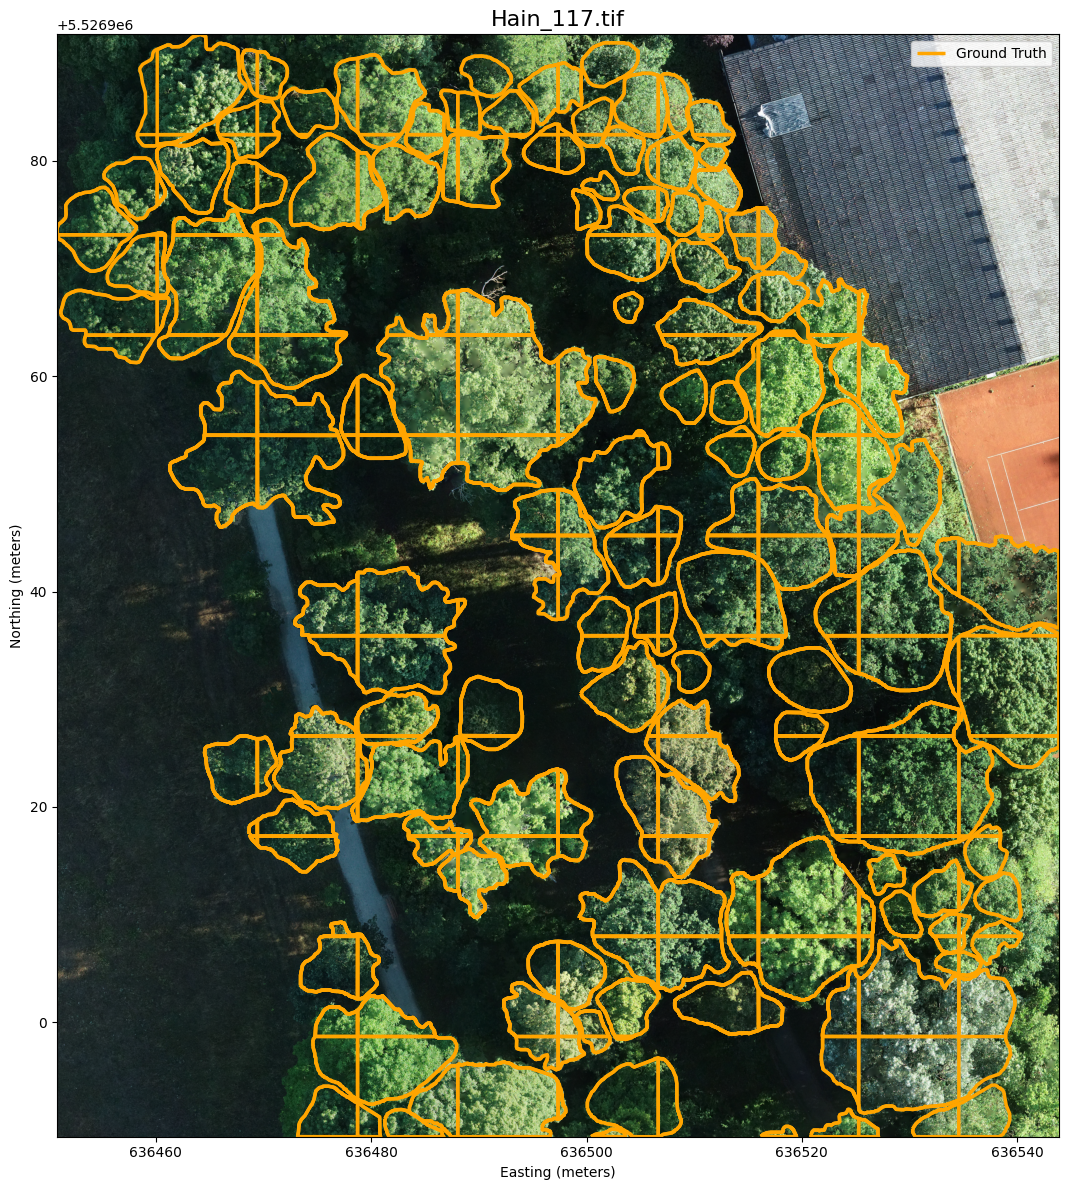

  Plotting: Hain_38.tif


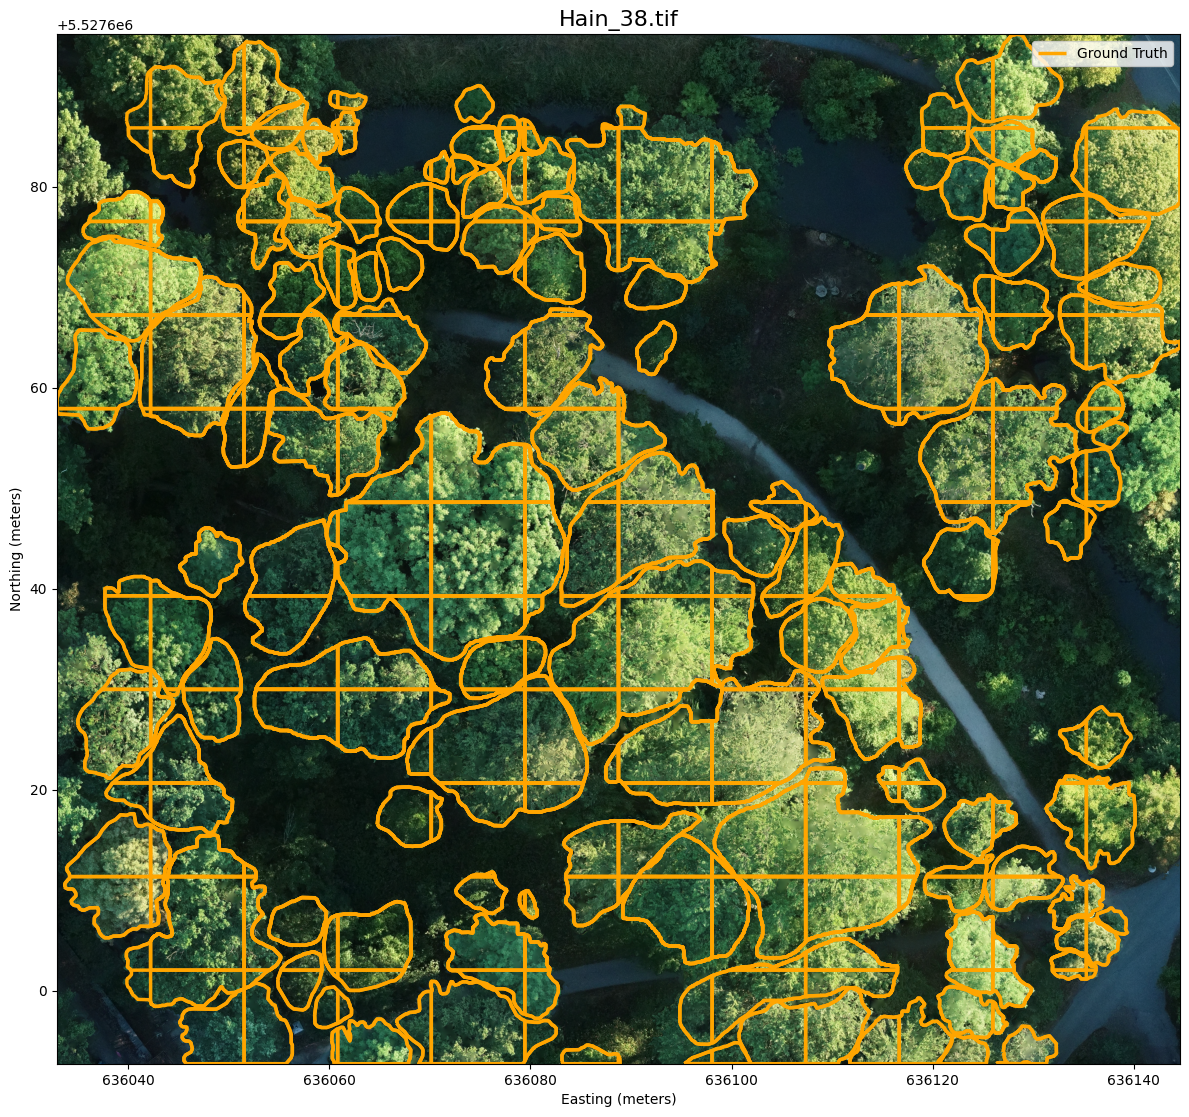

  Plotting: Hain_77.tif


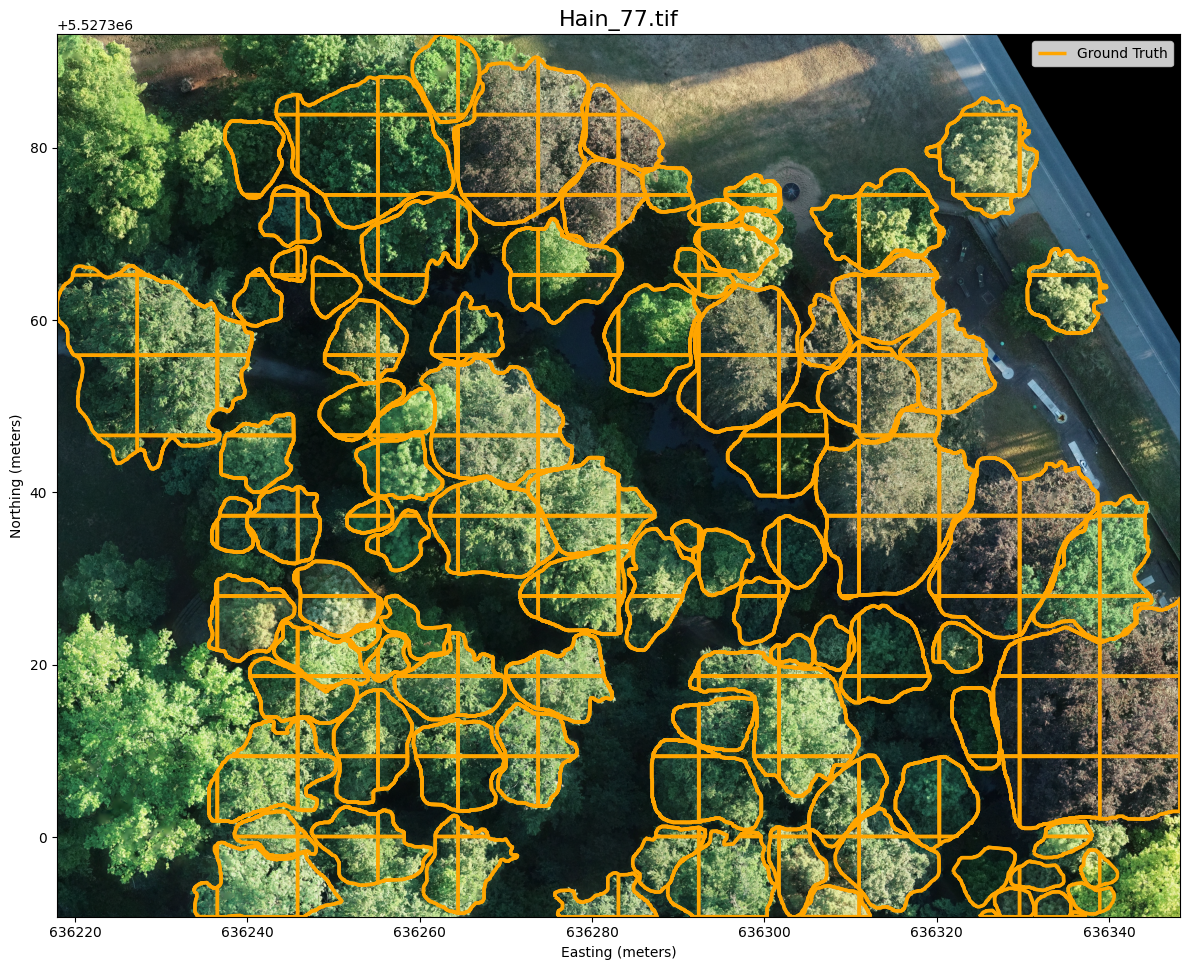

  Plotting: Hain_78.tif


In [ ]:
# Helper Function to convert annotations to GeoDataFrame
def pixel_polygons_to_geodataframe(segmentations, transform, crs, filename_for_error_logging=""):
    """
    Converts COCO-style pixel coordinates to a GeoDataFrame with world coordinates.
    Includes error handling for malformed polygon data.
    """
    polygons = []
    for seg in segmentations:
        if not seg: continue
        coords_flat = np.array(seg[0])
        if coords_flat.size % 2 != 0:
            print(f"  ⚠️ WARNING: Skipping a malformed polygon in '{filename_for_error_logging}'. "
                  f"It has an odd number of coordinates ({coords_flat.size}).")
            continue
        coords = coords_flat.reshape(-1, 2)
        world_coords = [rasterio.transform.xy(transform, c[1], c[0]) for c in coords]
        if len(world_coords) >= 3:
            polygons.append(Polygon(world_coords))
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    return gdf

def plot_image_with_annotations(image_path, annotations_gdf, title=""):
    """
    Opens a raster image, normalizes it for viewing, and plots a GeoDataFrame on top.
    """
    with rasterio.open(image_path) as src:
        image_data = src.read([1, 2, 3])
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

        # This scales the pixel values to the visible 0-255 range.
        min_val = image_data.min()
        max_val = image_data.max()
        if max_val > min_val:
            # Stretch the data to cover the full 0-255 range
            image_normalized = (255 * (image_data - min_val) / (max_val - min_val)).astype(np.uint8)
        else:
            # Handle the case of a single-color image
            image_normalized = np.zeros_like(image_data, dtype=np.uint8)

        # Move channels to the end for plotting: (C, H, W) -> (H, W, C)
        image_to_plot = np.moveaxis(image_normalized, 0, -1)

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(image_to_plot, extent=extent)

        if not annotations_gdf.empty:
            annotations_gdf.boundary.plot(ax=ax, edgecolor="orange", linewidth=2.5, label="Ground Truth")

        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Easting (meters)")
        ax.set_ylabel("Northing (meters)")
        ax.legend()
        plt.tight_layout()
        plt.show()


MERGED_IMG_DIR = "/content/drive/MyDrive/masterthesis/data/TestSet12023_imgs"
MERGED_JSON_PATH = "/content/drive/MyDrive/masterthesis/data/merged_annotations_for_manual_images.json"


print(f"Loading merged annotation data from: {MERGED_JSON_PATH}")
with open(MERGED_JSON_PATH, 'r') as f:
    coco_data = json.load(f)

annotations_by_filename = defaultdict(list)
images_map = {img['file_name']: img['id'] for img in coco_data['images']}
for ann in coco_data['annotations']:
    for img in coco_data['images']:
        if ann['image_id'] == img['id']:
            annotations_by_filename[img['file_name']].append(ann['segmentation'])
            break


print("\nGenerating plots for verification...")
for image_info in coco_data['images']:
    file_name = image_info['file_name']
    image_path = os.path.join(MERGED_IMG_DIR, file_name)

    print(f"  Plotting: {file_name}")

    if not os.path.exists(image_path):
        print(f"    ⚠️ WARNING: Image file not found at '{image_path}'. Skipping plot.")
        continue

    segmentations = annotations_by_filename[file_name]

    with rasterio.open(image_path) as src:
        transform = src.transform
        crs = src.crs

    annotations_gdf = pixel_polygons_to_geodataframe(segmentations, transform, crs, filename_for_error_logging=file_name)

    plot_image_with_annotations(image_path, annotations_gdf, title=file_name)

print("\n🎉 Verification plotting complete.")